# GDELT Demo Notebook

This notebook demonstrates working with GDELT (Global Database of Events, Language, and Tone) data for graph analysis.


In [ ]:
# Configuration variables
GCP_PROJECT_ID = "graph-demo-471710"  # Replace with your actual GCP project ID
PROJECT_REGION = "us-central1"
BIGQUERY_DATASET = "gdelt"  # Replace with your actual BigQuery dataset name
BIGQUERY_TABLES = ["gkg_partitioned", "events_partitioned","eventmentions_partitioned"]  # List of tables to copy
GDELT_PROJECT_ID = "gdelt-bq"
GDELT_DATASET = "gdeltv2"  
GDELT_REGION = "us"
GCS_BUCKET = "gdelt_graph"

# Derived variables - will be generated for each table
print(f"Configuration loaded:")
print(f"  GCP Project: {GCP_PROJECT_ID}")
print(f"  BigQuery Dataset: {BIGQUERY_DATASET}")
print(f"  BigQuery Tables: {BIGQUERY_TABLES}")
print(f"  GDELT Project: {GDELT_PROJECT_ID}")
print(f"  GDELT Dataset: {GDELT_DATASET}")
print(f"  GDELT Region: {GDELT_REGION}")
print(f"  GCS Bucket: {GCS_BUCKET}")

In [ ]:
# GCP Authentication Setup
import subprocess
import os
import shutil
from google.auth import default
from google.auth.exceptions import DefaultCredentialsError

def setup_gcp_authentication():
    """Complete GCP authentication setup with error handling"""
    print("🔐 Setting up GCP Authentication...")
    
    try:
        # Step 1: Try to use existing credentials first
        print("🔍 Checking for existing credentials...")
        try:
            credentials, default_project = default()
            print(f"✅ Found existing credentials for project: {default_project}")
            
            # If the project matches, we're good
            if default_project == GCP_PROJECT_ID:
                print(f"🎯 Project matches target project: {GCP_PROJECT_ID}")
                os.environ['GOOGLE_CLOUD_PROJECT'] = GCP_PROJECT_ID
                return credentials, GCP_PROJECT_ID
            else:
                print(f"⚠️  Project mismatch: {default_project} vs {GCP_PROJECT_ID}")
                print("🔄 Will re-authenticate with correct project...")
        except DefaultCredentialsError:
            print("❌ No existing credentials found")
            print("🔄 Will authenticate from scratch...")
        
        # Step 2: Clear old credentials if needed
        print("🗑️  Clearing old credentials...")
        adc_path = os.path.expanduser("~/.config/gcloud/application_default_credentials.json")
        if os.path.exists(adc_path):
            os.remove(adc_path)
            print("✅ Removed old application default credentials")
        
        # Step 3: Set the correct project
        print(f"🎯 Setting gcloud project to: {GCP_PROJECT_ID}")
        result = subprocess.run(['gcloud', 'config', 'set', 'project', GCP_PROJECT_ID], 
                              capture_output=True, text=True, check=True)
        print("✅ Project set successfully")
        
        # Step 4: Re-authenticate
        print("🔄 Re-authenticating with application default credentials...")
        print("   This will open a browser window for authentication...")
        
        result = subprocess.run(['gcloud', 'auth', 'application-default', 'login'], 
                              check=True)
        print("✅ Re-authentication successful")
        
        # Step 5: Set quota project to avoid warnings
        print("💰 Setting quota project...")
        try:
            subprocess.run(['gcloud', 'auth', 'application-default', 'set-quota-project', GCP_PROJECT_ID], 
                          capture_output=True, text=True, check=True)
            print("✅ Quota project set successfully")
        except:
            print("⚠️  Could not set quota project (this is usually fine)")
        
        # Step 6: Verify the setup
        print("🧪 Verifying authentication...")
        credentials, project = default()
        print(f"✅ Authentication successful - Project: {project}")
        
        # Set environment variable
        os.environ['GOOGLE_CLOUD_PROJECT'] = GCP_PROJECT_ID
        print(f"🌍 Set GOOGLE_CLOUD_PROJECT environment variable to: {GCP_PROJECT_ID}")
        
        return credentials, GCP_PROJECT_ID
        
    except subprocess.CalledProcessError as e:
        print(f"❌ Command failed: {e}")
        print("💡 Manual steps required:")
        print(f"   1. gcloud config set project {GCP_PROJECT_ID}")
        print("   2. gcloud auth application-default login")
        print(f"   3. gcloud auth application-default set-quota-project {GCP_PROJECT_ID}")
        return None, None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None

# Run authentication setup
credentials, authenticated_project = setup_gcp_authentication()


In [ ]:
# Import required libraries
import os
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
import json
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt

print("✅ All libraries imported successfully!")
print("   - BigQuery and Cloud Storage clients ready")
print("   - NetworkX and Matplotlib ready for visualization")
print("   - Pandas ready for data processing")


In [ ]:
# Test GCP connectivity
def test_gcp_connectivity():
    """Test basic connectivity to GCP services"""
    print("🔍 Testing GCP connectivity...")
    
    # Check if authentication was successful
    if not credentials or not authenticated_project:
        print("❌ Authentication required - please run the authentication cell first")
        return False
    
    print(f"✅ Using authenticated project: {authenticated_project}")
    
    # Test 1: Test BigQuery connectivity
    try:
        # Use explicit credentials and project
        client = bigquery.Client(credentials=credentials, project=authenticated_project)
        print(f"🔗 BigQuery client created for project: {client.project}")
        
        # Simple query to test connectivity
        query = "SELECT 1 as test_value"
        result = client.query(query).result()
        for row in result:
            print(f"✅ BigQuery connectivity successful - Test query result: {row.test_value}")
            break  # Only need first row
    except Exception as e:
        error_str = str(e)
        if "has been deleted" in error_str or "USER_PROJECT_DENIED" in error_str:
            print(f"❌ BigQuery connectivity failed: Project mismatch detected")
            print(f"   Error: {e}")
            print(f"🔧 This usually means your credentials are cached for a different project")
            print(f"   💡 Try running the authentication cell again")
            print(f"   📋 Or manually run: gcloud auth application-default login")
            return False
        else:
            print(f"❌ BigQuery connectivity failed: {e}")
            return False
    
    # Test 2: Test BigQuery dataset access
    try:
        client = bigquery.Client(credentials=credentials, project=authenticated_project)
        dataset_ref = client.dataset(BIGQUERY_DATASET)
        dataset = client.get_dataset(dataset_ref)
        print(f"✅ BigQuery dataset '{BIGQUERY_DATASET}' accessible")
        
        # List tables in the dataset
        tables = list(client.list_tables(dataset_ref))
        print(f"📊 Found {len(tables)} tables in dataset")
        for table in tables[:5]:  # Show first 5 tables
            print(f"   - {table.table_id}")
        if len(tables) > 5:
            print(f"   ... and {len(tables) - 5} more tables")
            
    except Exception as e:
        print(f"❌ BigQuery dataset access failed: {e}")
        print(f"   Make sure dataset '{BIGQUERY_DATASET}' exists in project '{authenticated_project}'")
        return False
    
    # Test 3: Test Cloud Storage connectivity
    try:
        storage_client = storage.Client(credentials=credentials, project=authenticated_project)
        # List buckets to test connectivity
        buckets = list(storage_client.list_buckets())
        print(f"✅ Cloud Storage connectivity successful - Found {len(buckets)} buckets")
    except Exception as e:
        print(f"❌ Cloud Storage connectivity failed: {e}")
        return False
    
    print("🎉 All GCP connectivity tests passed!")
    return True

# Run the connectivity test
test_gcp_connectivity()


In [ ]:
# Ready for GDELT analysis!
print("🎉 Setup complete! Ready to work with GDELT data.")
print(f"📊 Project: {GCP_PROJECT_ID}")
print(f"🗄️  Dataset: {BIGQUERY_DATASET}")
print("🚀 You can now run queries against your GDELT data!")


In [ ]:
# List datasets in the GDELT_PROJECT_ID project
def list_gdelt_datasets():
    """List all datasets in the GDELT_PROJECT_ID project"""
    print(f"🔍 Listing datasets in GDELT project: {GDELT_PROJECT_ID}")
    
    try:
        # Create BigQuery client for the GDELT project
        gdelt_client = bigquery.Client(project=GDELT_PROJECT_ID)
        print(f"✅ Connected to GDELT project: {gdelt_client.project}")
        
        # List all datasets in the project
        datasets = list(gdelt_client.list_datasets())
        
        if not datasets:
            print("📭 No datasets found in the GDELT project")
            return []
        
        print(f"📊 Found {len(datasets)} datasets in {GDELT_PROJECT_ID}:")
        print("-" * 60)
        
        dataset_info = []
        for dataset in datasets:
            # Get dataset details
            dataset_ref = gdelt_client.dataset(dataset.dataset_id)
            full_dataset = gdelt_client.get_dataset(dataset_ref)
            
            # Count tables in the dataset
            tables = list(gdelt_client.list_tables(dataset_ref))
            
            info = {
                'dataset_id': dataset.dataset_id,
                'description': full_dataset.description or 'No description',
                'created': full_dataset.created,
                'modified': full_dataset.modified,
                'location': full_dataset.location,
                'table_count': len(tables)
            }
            dataset_info.append(info)
            
            print(f"📁 Dataset: {dataset.dataset_id}")
            print(f"   Description: {info['description']}")
            print(f"   Created: {info['created']}")
            print(f"   Modified: {info['modified']}")
            print(f"   Location: {info['location']}")
            print(f"   Tables: {info['table_count']}")
            
            # Show first few tables if any
            if tables:
                print(f"   Sample tables:")
                for table in tables[:5]:
                    print(f"     - {table.table_id}")
                if len(tables) > 5:
                    print(f"     ... and {len(tables) - 5} more")
            print()
        
        return dataset_info
        
    except Exception as e:
        print(f"❌ Error listing datasets: {e}")
        return []

# Run the function to list datasets
gdelt_datasets = list_gdelt_datasets()


## Cross-Region GDELT Data Copy Function

This function efficiently copies GDELT data from the US region to your local US-CENTRAL1 region using a smart multi-step approach:

### 🎯 **Purpose**
- Copies GDELT data for a specific date (September 11, 2025) from the public GDELT dataset
- Handles cross-region data transfer from US region to US-CENTRAL1 region
- Optimizes for cost and speed with intelligent caching

### 🔄 **Process Flow**
1. **Destination Check**: Verifies if target table already exists (skips if data present)
2. **Dataset Setup**: Creates required datasets in both US and US-CENTRAL1 regions
3. **Temporary Table Check**: Checks if temp table exists in US region (reuses if available)
4. **Data Query**: Queries GDELT data and saves to temporary table in US region
5. **Cross-Region Copy**: Copies data from US region to US-CENTRAL1 region
6. **Cleanup**: Removes temporary table and verifies final data

### ⚡ **Optimizations**
- **Smart Caching**: Skips expensive operations if data already exists
- **Cost Efficient**: Reuses temporary tables when possible
- **Error Resilient**: Handles various BigQuery errors gracefully
- **Progress Tracking**: Detailed logging throughout the process

### 📊 **Output**
- Creates table: `{GCP_PROJECT_ID}.gdelt.gkg_partitioned` in US-CENTRAL1 region
- Shows row counts and verification details
- Provides troubleshooting tips if errors occur


In [ ]:
# Copy GDELT data for specific partition (September 11, 2025) - Cross-region approach for multiple tables
from google.cloud import bigquery
from datetime import datetime

def copy_gdelt_partition_cross_region():
    """
    Copy data from GDELT tables (US region) to local tables (US-CENTRAL1 region).
    Uses a temporary table approach to handle cross-region data access.
    Processes each table in BIGQUERY_TABLES list.
    """
    print("�� Starting cross-region GDELT data copy for multiple tables...")
    print(f" Target date: September 11, 2025")
    print(f" Source: GDELT tables in {GDELT_PROJECT_ID}.{GDELT_DATASET} (US region)")
    print(f" Destination: {GCP_PROJECT_ID}.{BIGQUERY_DATASET} (US-CENTRAL1 region)")
    print(f" Tables to process: {BIGQUERY_TABLES}")
    print("-" * 70)
    
    results = {}
    
    try:
        # Create BigQuery client
        local_client = bigquery.Client(project=GCP_PROJECT_ID)
        print("✅ BigQuery client created")
        
        # Step 0: Create dataset if it doesn't exist (same for all tables)
        print(f" Checking if dataset '{BIGQUERY_DATASET}' exists...")
        dataset_ref = local_client.dataset(BIGQUERY_DATASET)
        
        try:
            dataset = local_client.get_dataset(dataset_ref)
            print(f"✅ Dataset '{BIGQUERY_DATASET}' already exists")
        except Exception:
            print(f"📝 Dataset '{BIGQUERY_DATASET}' doesn't exist, creating it...")
            
            # Create dataset with proper location
            dataset = bigquery.Dataset(dataset_ref)
            dataset.location = "US-CENTRAL1"  # Specify the region
            dataset.description = "GDELT data for graph analysis"
            
            dataset = local_client.create_dataset(dataset, timeout=30)
            print(f"✅ Dataset '{BIGQUERY_DATASET}' created successfully in us-central1")
        
        # Step 1: Create dataset in US region for temporary tables
        print("📝 Creating dataset in US region for temporary tables...")
        us_dataset_name = f"{BIGQUERY_DATASET}_us"
        us_dataset_ref = bigquery.DatasetReference(GCP_PROJECT_ID, us_dataset_name)
        
        try:
            us_dataset = local_client.get_dataset(us_dataset_ref)
            print(f"✅ Dataset '{us_dataset_name}' already exists in US region")
        except Exception as e:
            if "notFound" in str(e) or "404" in str(e):
                print(f"📝 Creating dataset '{us_dataset_name}' in US region...")
                us_dataset = bigquery.Dataset(us_dataset_ref)
                us_dataset.location = "US"
                us_dataset.description = "GDELT data for graph analysis (US region - temporary)"
                try:
                    us_dataset = local_client.create_dataset(us_dataset, timeout=30)
                    print(f"✅ Dataset '{us_dataset_name}' created in US region")
                except Exception as create_error:
                    if "Already Exists" in str(create_error) or "409" in str(create_error):
                        print(f"✅ Dataset '{us_dataset_name}' already exists in US region (created by another process)")
                    else:
                        raise create_error
            else:
                print(f"⚠️  Unexpected error checking dataset in US region: {e}")
                raise e
        
        # Process each table
        for i, table_name in enumerate(BIGQUERY_TABLES, 1):
            print(f"\n{'='*80}")
            print(f"�� Processing table {i}/{len(BIGQUERY_TABLES)}: {table_name}")
            print(f"{'='*80}")
            
            try:
                # Create GDELT table reference for this table
                gdelt_table = f"{GDELT_PROJECT_ID}.{GDELT_DATASET}.{table_name}"
                
                # Check if destination table already exists
                print(f"🔍 Checking if destination table '{table_name}' already exists...")
                dest_table_ref = f"{GCP_PROJECT_ID}.{BIGQUERY_DATASET}.{table_name}"
                try:
                    existing_dest_table = local_client.get_table(dest_table_ref)
                    print(f"✅ Destination table already exists: {existing_dest_table.full_table_id}")
                    print(f"   Rows: {existing_dest_table.num_rows:,}")
                    print("⏭️  Skipping data copy process, destination table already has data")
                    
                    # Optional: Verify the data is for the correct date
                    print("🔍 Verifying existing data...")
                    try:
                        simple_query = f"SELECT COUNT(*) as row_count FROM `{dest_table_ref}`"
                        result = local_client.query(simple_query, location="US-CENTRAL1").result()
                        for row in result:
                            print(f"�� Existing data summary:")
                            print(f"   Total rows: {row.row_count:,}")
                            print("✅ Data verification completed")
                    except Exception as verify_error:
                        print(f"⚠️  Could not verify existing data: {verify_error}")
                    
                    results[table_name] = {"status": "skipped", "reason": "already_exists"}
                    continue
                    
                except Exception as e:
                    if "notFound" in str(e) or "404" in str(e):
                        print("📝 Destination table doesn't exist, proceeding with data copy...")
                    else:
                        print(f"⚠️  Error checking destination table: {e}")
                        print("📝 Proceeding with data copy...")
                
                # Check if temporary table already exists, if not query GDELT data
                temp_table_ref = local_client.dataset(us_dataset_name).table(f"temp_{table_name}")
                
                print("🔍 Checking if temporary table already exists...")
                try:
                    existing_temp_table = local_client.get_table(temp_table_ref)
                    print(f"✅ Temporary table already exists: {existing_temp_table.full_table_id}")
                    print(f"   Rows: {existing_temp_table.num_rows:,}")
                    print("⏭️  Skipping data query, using existing temporary table")
                except Exception as e:
                    if "notFound" in str(e) or "404" in str(e):
                        print("📊 Temporary table doesn't exist, querying GDELT data and saving to temporary table...")
                        
                        # Configure the query job to save to temporary table in US region
                        job_config = bigquery.QueryJobConfig()
                        job_config.destination = temp_table_ref
                        job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
                        job_config.create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED
                        
                        # Query the GDELT table
                        query = f"""
                        SELECT *
                        FROM `{gdelt_table}`
                        WHERE _PARTITIONTIME = TIMESTAMP('2025-09-11')
                        """
                        
                        print("📊 Executing query...")
                        print(f"🔍 Query: {query}")
                        print(f"🎯 Destination: {GCP_PROJECT_ID}.{us_dataset_name}.temp_{table_name}")
                        
                        # Run the query - this will automatically handle cross-region data transfer
                        query_job = local_client.query(
                            query,
                            job_config=job_config,
                            location="US"  # Query in US region where GDELT table exists
                        )
                        
                        print(f"⏳ Query job started: {query_job.job_id}")
                        print("⏳ Waiting for query to complete...")
                        query_job.result()  # Wait for job to complete
                        print("✅ Data copied to temporary table in US region")
                    else:
                        print(f"⚠️  Unexpected error checking temporary table: {e}")
                        raise e
                
                # Define source table reference
                source_table_ref = bigquery.TableReference.from_string(f"{GCP_PROJECT_ID}.{us_dataset_name}.temp_{table_name}")
                
                # Copy data from US region temp table to US-CENTRAL1 region
                print("🔄 Copying data from US region to US-CENTRAL1 region...")
                
                # Configure the copy job
                copy_job_config = bigquery.CopyJobConfig()
                copy_job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
                copy_job_config.create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED
                
                # Destination table (in US-CENTRAL1 region)
                dest_table_ref = local_client.dataset(BIGQUERY_DATASET).table(table_name)
                
                # Copy the data - need to specify source location
                copy_job = local_client.copy_table(
                    source_table_ref,
                    dest_table_ref,
                    job_config=copy_job_config,
                    location="US"  # Source is in US region
                )
                
                print(f"⏳ Copy job started: {copy_job.job_id}")
                print("⏳ Waiting for copy to complete...")
                copy_job.result()  # Wait for job to complete
                print("✅ Data copied to US-CENTRAL1 region successfully")
                
                # Clean up temporary table
                print("🧹 Cleaning up temporary table...")
                try:
                    local_client.delete_table(source_table_ref)
                    print("✅ Temporary table deleted")
                except Exception as e:
                    print(f"⚠️  Could not delete temporary table: {e}")
                
                # Verify the data
                print("🔍 Verifying imported data...")
                
                try:
                    table = local_client.get_table(f"{GCP_PROJECT_ID}.{BIGQUERY_DATASET}.{table_name}")
                    print(f"✅ Table found: {table.full_table_id}")
                    print(f"   Rows: {table.num_rows:,}")
                    print(f"   Columns: {len(table.schema)}")
                    
                    # Try a simple count query first
                    simple_verification_query = f"""
                    SELECT COUNT(*) as row_count
                    FROM `{GCP_PROJECT_ID}.{BIGQUERY_DATASET}.{table_name}`
                    """
                    
                    verification_result = local_client.query(simple_verification_query, location="US-CENTRAL1").result()
                    for row in verification_result:
                        print(f"📊 Imported data summary:")
                        print(f"   Total rows: {row.row_count:,}")
                        
                    results[table_name] = {"status": "success", "rows": table.num_rows}
                    
                except Exception as e:
                    print(f"❌ Error during verification: {e}")
                    print("💡 Table may have been created but verification failed")
                    results[table_name] = {"status": "partial_success", "error": str(e)}
                
            except Exception as e:
                print(f"❌ Error processing table '{table_name}': {e}")
                results[table_name] = {"status": "failed", "error": str(e)}
                print(f"⚠️  Continuing with next table...")
        
        # Print final summary
        print(f"\n{'='*80}")
        print("📊 FINAL SUMMARY")
        print(f"{'='*80}")
        
        success_count = sum(1 for r in results.values() if r["status"] == "success")
        skipped_count = sum(1 for r in results.values() if r["status"] == "skipped")
        failed_count = sum(1 for r in results.values() if r["status"] == "failed")
        partial_count = sum(1 for r in results.values() if r["status"] == "partial_success")
        
        print(f"✅ Successfully processed: {success_count}/{len(BIGQUERY_TABLES)} tables")
        print(f"⏭️  Skipped (already exists): {skipped_count}/{len(BIGQUERY_TABLES)} tables")
        print(f"⚠️  Partial success: {partial_count}/{len(BIGQUERY_TABLES)} tables")
        print(f"❌ Failed: {failed_count}/{len(BIGQUERY_TABLES)} tables")
        
        print(f"\nDetailed results:")
        for table_name, result in results.items():
            status_emoji = {
                "success": "✅",
                "skipped": "⏭️",
                "partial_success": "⚠️",
                "failed": "❌"
            }.get(result["status"], "❓")
            
            print(f"  {status_emoji} {table_name}: {result['status']}")
            if "rows" in result:
                print(f"      Rows: {result['rows']:,}")
            if "error" in result:
                print(f"      Error: {result['error']}")
        
        print(f"\n🎉 Multi-table cross-region data copy completed!")
        return results
        
    except Exception as e:
        print(f"❌ Critical error during data copy: {e}")
        print("💡 Troubleshooting tips:")
        print("   - Check if the GDELT tables exist and are accessible")
        print("   - Verify your project has BigQuery API enabled")
        print("   - Ensure you have the necessary permissions")
        return results

# Run the cross-region copy process for multiple tables
copy_results = copy_gdelt_partition_cross_region()

In [97]:
# Query to find person co-occurrence patterns
def query_person_cooccurrence(search_person="Kennedy"):
    """
    Query to find person co-occurrence patterns for a specified person in GDELT data.
    This query identifies which people appear together with the specified person in the same articles.
    """
    
    print(f"🔍 Querying person co-occurrence patterns for '{search_person}'...")
    
    # The BigQuery SQL query
    query = f"""
    WITH ArticleNames AS (
      SELECT DISTINCT  -- DISTINCT moves here to apply to the whole row
        GKGRECORDID,
        REGEXP_REPLACE(person, r',.*', '') AS name -- DISTINCT removed from this line
      FROM
        `gdelt.gkg_partitioned`,
        UNNEST(SPLIT(V2Persons, ';')) AS person
      WHERE V2Persons LIKE '%{search_person}%'
    )
    -- This section creates the pairs by joining the table to itself
    SELECT
      a.name AS name1,
      b.name AS name2,
      COUNT(*) AS pair_count
    FROM
      ArticleNames AS a
    JOIN
      ArticleNames AS b ON a.GKGRECORDID = b.GKGRECORDID
    WHERE
      a.name < b.name -- This avoids duplicates and self-pairs
    GROUP BY
      1, 2
    ORDER BY
      pair_count DESC
    LIMIT 250;
    """
    
    try:
        # Create BigQuery client
        client = bigquery.Client(project=GCP_PROJECT_ID)
        print(f"✅ Connected to BigQuery project: {GCP_PROJECT_ID}")
        
        # Execute the query
        print("📊 Executing query...")
        print(f"🔍 Query: Finding person co-occurrence patterns for '{search_person}'")
        
        query_job = client.query(query, location="US-CENTRAL1")
        results = query_job.result()
        
        # Process results manually (simple approach)
        print("📋 Processing results...")
        rows = []
        for row in results:
            rows.append({
                'name1': row.name1,
                'name2': row.name2,
                'pair_count': row.pair_count
            })
        
        # Create DataFrame manually
        df = pd.DataFrame(rows)
        print("✅ Results processed successfully")
        
        print(f"✅ Query completed successfully!")
        print(f"📊 Found {len(df)} person co-occurrence pairs")
        print("\n" + "="*80)
        print(f"📈 TOP PERSON CO-OCCURRENCE PATTERNS WITH '{search_person.upper()}'")
        print("="*80)
        
        if len(df) > 0:
            # Display the results
            print(df.to_string(index=False))
            
            # Show some statistics
            print(f"\n📊 Summary Statistics:")
            print(f"   Total pairs found: {len(df)}")
            print(f"   Highest co-occurrence count: {df['pair_count'].max()}")
            print(f"   Average co-occurrence count: {df['pair_count'].mean():.2f}")
            
            # Show the top 10 most frequent co-occurrences
            print(f"\n🏆 TOP 10 MOST FREQUENT CO-OCCURRENCES:")
            print("-" * 60)
            top_10 = df.head(10)
            for idx, row in top_10.iterrows():
                print(f"{idx+1:2d}. {row['name1']} & {row['name2']} - {row['pair_count']} times")
        else:
            print(f"❌ No co-occurrence patterns found for '{search_person}'")
            print("💡 This could mean:")
            print(f"   - No articles contain '{search_person}' in the V2Persons field")
            print("   - The data might not be loaded for the target date")
            print("   - There might be a spelling variation in the data")
        
        return df
        
    except Exception as e:
        print(f"❌ Error executing query: {e}")
        print("💡 Troubleshooting tips:")
        print("   - Check if the gkg_partitioned table exists and has data")
        print("   - Verify the table has V2Persons column")
        print("   - Ensure you have the necessary BigQuery permissions")
        return None

# Execute the query
search_person = "Robert F Kennedy Jr"  # Define the search person here
cooccurrence_results = query_person_cooccurrence(search_person)


🔍 Querying person co-occurrence patterns for 'Robert F Kennedy Jr'...
✅ Connected to BigQuery project: graph-demo-471710
📊 Executing query...
🔍 Query: Finding person co-occurrence patterns for 'Robert F Kennedy Jr'
📋 Processing results...
✅ Results processed successfully
✅ Query completed successfully!
📊 Found 250 person co-occurrence pairs

📈 TOP PERSON CO-OCCURRENCE PATTERNS WITH 'ROBERT F KENNEDY JR'
                    name1                     name2  pair_count
             Donald Trump       Robert F Kennedy Jr          28
             Charlie Kirk       Robert F Kennedy Jr          26
             Charlie Kirk              Donald Trump          26
             Donald Trump              Josh Shapiro          15
         Gretchen Whitmer              Josh Shapiro          15
         Gretchen Whitmer       Robert F Kennedy Jr          15
       Gabrielle Giffords             Steve Scalise          15
       Gabrielle Giffords          Gretchen Whitmer          15
             Dona

🕸️  Creating network graph from co-occurrence data...
✅ Graph created with 46 nodes and 250 edges


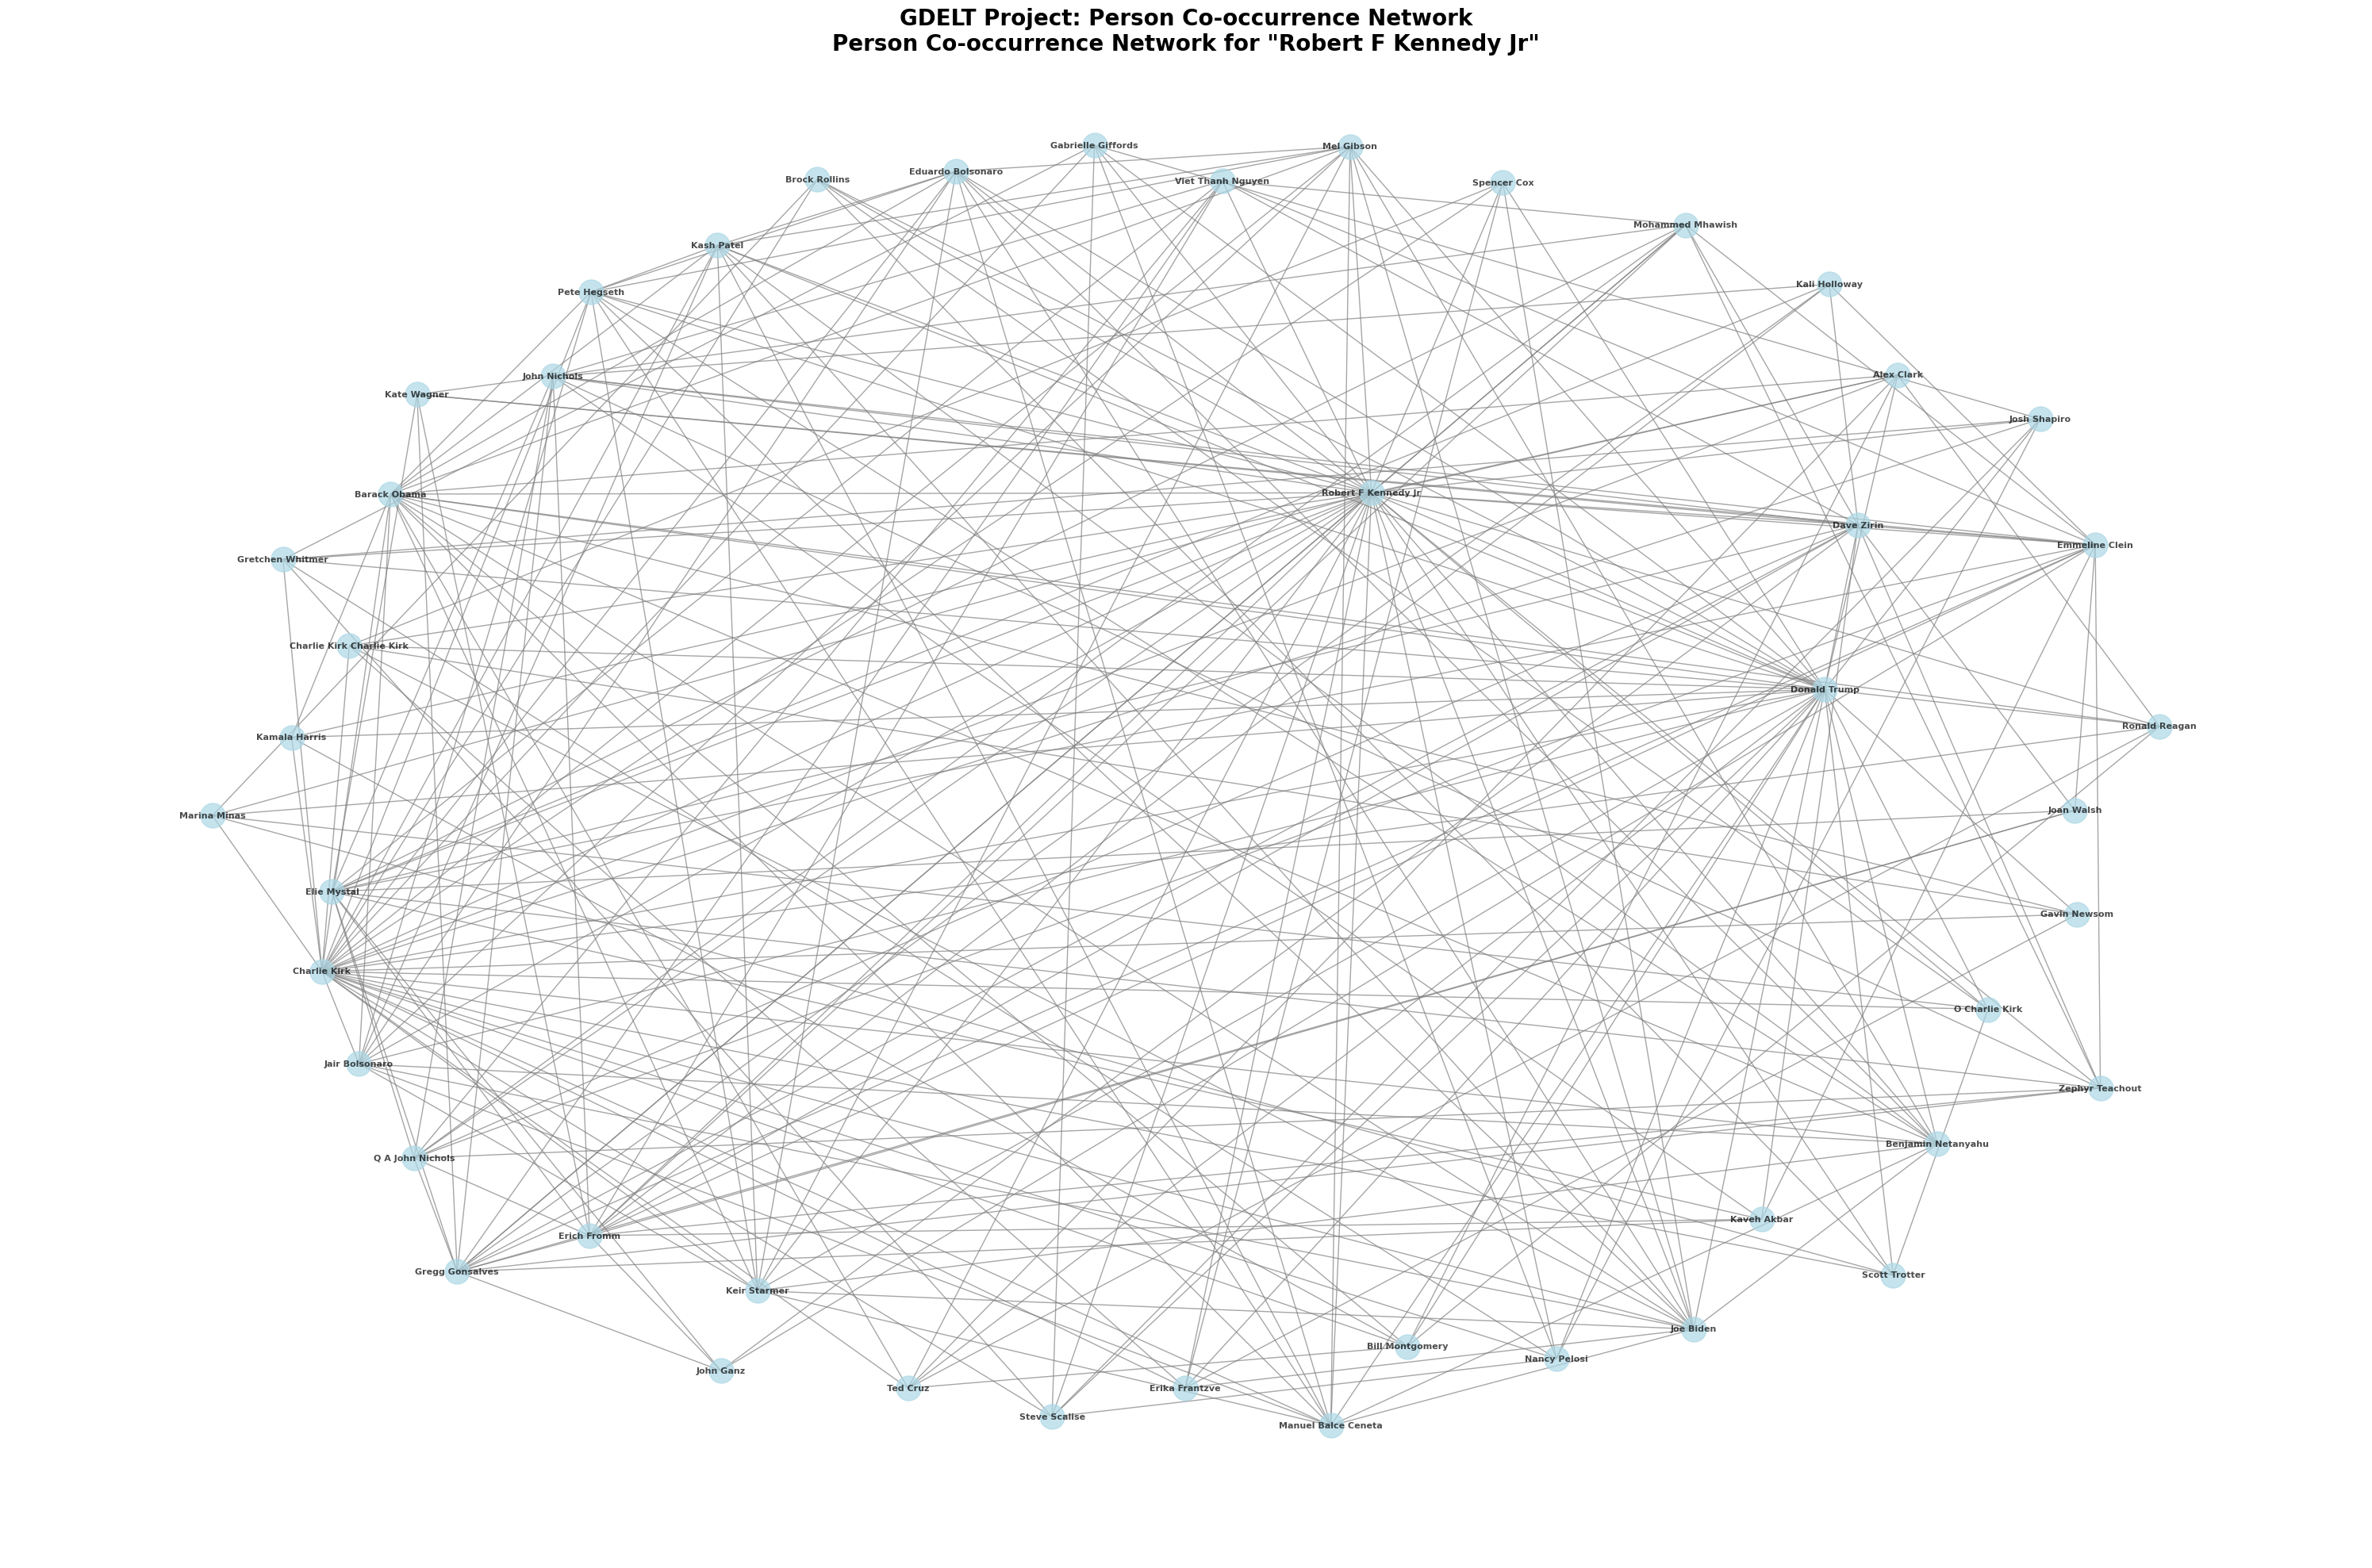


📊 Network Statistics:
   Nodes: 46
   Edges: 250
   Average degree: 10.87

🏆 Most Connected Nodes:
   1. Robert F Kennedy Jr: 0.822
   2. Donald Trump: 0.689
   3. Charlie Kirk: 0.667
   4. Barack Obama: 0.400
   5. Dave Zirin: 0.356


In [99]:
# Create network visualization from co-occurrence results
def create_person_network_graph(df, search_person="Rayner", title="Person Co-occurrence Network"):
    """
    Create a network graph from the co-occurrence DataFrame
    """
    print("🕸️  Creating network graph from co-occurrence data...")
    
    if df is None or len(df) == 0:
        print("❌ No data available to create network graph")
        return None
    
    # Create the graph
    g = nx.Graph()
    
    # Add edges with weights based on co-occurrence count
    for _, row in df.iterrows():
        name1 = row['name1']
        name2 = row['name2']
        weight = row['pair_count']
            
        # Add edge with weight (scaled down for visualization)
        g.add_edge(name1, name2, weight=weight/10)
    
    print(f"✅ Graph created with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges")
    
    # Create the visualization
    plt.figure(figsize=(30, 20))
    plt.title(f'GDELT Project: {title}\nPerson Co-occurrence Network for "{search_person}"', 
              y=0.97, fontsize=20, fontweight='bold')
    
    # Draw the network
    pos = nx.spring_layout(g, k=3, iterations=50)  # Layout algorithm
    nx.draw(g, pos, 
            with_labels=True, 
            node_color='lightblue',
            node_size=500,
            font_size=8,
            font_weight='bold',
            edge_color='gray',
            alpha=0.7)
    
    # Add edge labels for weights (only for top edges to avoid clutter)
    edge_labels = {}
    for (u, v, d) in g.edges(data=True):
        if d['weight'] > 5:  # Only show labels for significant connections
            edge_labels[(u, v)] = f"{d['weight']:.1f}"
    
    nx.draw_networkx_edge_labels(g, pos, edge_labels, font_size=6)
    
    plt.tight_layout()
    plt.show()
    
    # Print some network statistics
    print(f"\n📊 Network Statistics:")
    print(f"   Nodes: {g.number_of_nodes()}")
    print(f"   Edges: {g.number_of_edges()}")
    print(f"   Average degree: {sum(dict(g.degree()).values()) / g.number_of_nodes():.2f}")
    
    # Find the most connected nodes
    degree_centrality = nx.degree_centrality(g)
    top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n🏆 Most Connected Nodes:")
    for i, (node, centrality) in enumerate(top_nodes, 1):
        print(f"   {i}. {node}: {centrality:.3f}")
    
    return g

# Create the network graph from the co-occurrence results
network_graph = create_person_network_graph(cooccurrence_results, search_person)
